In [1]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
from tensorflow.python.framework.errors_impl import DataLossError
from collections import defaultdict
import os, csv
import re
import time

In [2]:
def replace_spaces_recursive(directory):
    """
    Recursively replaces spaces in all file names in the given directory and its subdirectories with underscores.
    
    Args:
        directory (str): The root directory to start from.
    
    Returns:
        None
    """
    for root, _, files in os.walk(directory):  # Recursively walk through all directories
        for filename in files:
            old_path = os.path.join(root, filename)  # Full path of the file
            
            if " " in filename:  # Only process files with spaces in the name
                new_filename = filename.replace(" ", "_")  # Replace spaces with underscores
                new_path = os.path.join(root, new_filename)  # New file path
                
                os.rename(old_path, new_path)  # Rename the file
                print(f'Renamed: "{old_path}" → "{new_path}"')

In [168]:
replace_spaces_recursive('../analysis/res')

Renamed: "../analysis/res/multiagent_test_v1_20250210-23021739248088/Agent_2_selection sum freq_data.csv" → "../analysis/res/multiagent_test_v1_20250210-23021739248088/Agent_2_selection_sum_freq_data.csv"
Renamed: "../analysis/res/multiagent_test_v1_20250210-23021739248088/Agent_1_selection sum freq_data.csv" → "../analysis/res/multiagent_test_v1_20250210-23021739248088/Agent_1_selection_sum_freq_data.csv"
Renamed: "../analysis/res/multiagent_test_v1_20250210-23021739248088/Agent_0_selection sum freq_data.csv" → "../analysis/res/multiagent_test_v1_20250210-23021739248088/Agent_0_selection_sum_freq_data.csv"
Renamed: "../analysis/res/multiagent_test_v1_20250210-23021739248088/Agent_1_selection freq_Agent_2_selected/Agent_1_selection freq_data.csv" → "../analysis/res/multiagent_test_v1_20250210-23021739248088/Agent_1_selection freq_Agent_2_selected/Agent_1_selection_freq_data.csv"
Renamed: "../analysis/res/multiagent_test_v1_20250210-23021739248088/occurence sum freq_Agent_2/occurence su

Preprocessing: Convert tensorboard event files to csv

In [3]:
def tensorboard_to_csv(event_file, csv_file):
    """
    Convert TensorBoard event file data to a CSV format.

    Args:
        event_file (str): Path to the TensorBoard event file (e.g., events.out.tfevents.xxx).
        csv_file (str): Path where the output CSV file should be saved.
    """
    # Create a list to store the data rows
    data_rows = []
    
    # Use tf.compat.v1 to access the summary_iterator in TensorFlow 2.x
    for e in tf.compat.v1.train.summary_iterator(event_file):
        for v in e.summary.value:
            # Only consider scalar summaries
            if v.HasField('simple_value'):
                tag = v.tag
                value = v.simple_value
                step = e.step
                data_rows.append([step, tag, value])
    
    # Write the extracted data into a CSV file
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(['Step', 'Tag', 'Value'])
        # Write the data rows
        writer.writerows(data_rows)
    
    print(f"Data from {event_file} has been written to {csv_file}")


In [4]:
def tensorboard_to_separate_csv(event_file, output_dir):
    """
    Convert TensorBoard event file data to separate CSV files for each tag.
    """
    tag_data = defaultdict(list)

    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            try:
                # Process individual records
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        tag = v.tag
                        value = v.simple_value
                        step = e.step
                        tag_data[tag].append([step, value])
            except Exception as record_error:
                # Log a warning and skip problematic records
                print(f"Skipped a corrupt record in file: {event_file}")
    except DataLossError:
        # Log and continue for files with partial writes
        print(f"Encountered DataLossError. Possibly due to incomplete writes in file: {event_file}")

    # Save tag data to CSV files
    for tag, data_rows in tag_data.items():
        filename = f"{output_dir}/{tag.replace('/', '_')}_data.csv"
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Step', 'Value'])
            writer.writerows(data_rows)
        print(f"Data for tag '{tag}' has been written to {filename}")


In [6]:
def is_file_stable(file_path, wait_time=1.0):
    initial_size = os.path.getsize(file_path)
    time.sleep(wait_time)
    final_size = os.path.getsize(file_path)
    return initial_size == final_size

def process_tensorboard_results(parent_dir, output_parent_dir):
    """
    Loop through all subdirectories of a parent directory, process TensorBoard files,
    and save results to a corresponding directory structure.

    Args:
        parent_dir (str): Parent directory containing TensorBoard event files.
        output_parent_dir (str): Parent directory where CSV files should be saved.
    """
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "tfevents" in file:  # Check if the file is a TensorBoard event file
                event_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, parent_dir)
                output_dir = os.path.join(output_parent_dir, relative_path)
                os.makedirs(output_dir, exist_ok=True)

                # Check if the file is stable
                if not is_file_stable(event_file):
                    print(f"File is still being written: {event_file}, skipping.")
                    continue

                try:
                    tensorboard_to_separate_csv(event_file, output_dir)
                    print(f"Processed {event_file} -> {output_dir}")
                except Exception as e:
                    print(f"Failed to process {event_file}: {e}")

def process_tensorboard_results(parent_dir, output_parent_dir, skip_existing=True, skip_existing_by_time=False):
    """
    Loop through all subdirectories of a parent directory, process TensorBoard files,
    and save results to a corresponding directory structure, skipping already processed files.

    Args:
        parent_dir (str): Parent directory containing TensorBoard event files.
        output_parent_dir (str): Parent directory where CSV files should be saved.
    """
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "tfevents" in file:  # Check if the file is a TensorBoard event file
                event_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, parent_dir)
                output_dir = os.path.join(output_parent_dir, relative_path)
                
                # Skip processing if output file already exists
                if skip_existing:
                    if os.path.exists(output_dir):
                        print(f"Skipping already processed file: {event_file}")
                        continue

                if skip_existing_by_time:
                    N = 4  # Time filter in hours
                    # Get current time
                    now = time.time()
                    mod_time = os.path.getmtime(event_file)
                    # Check if the file was modified in the last N hours
                    if (now - mod_time) > N * 3600:
                        print(f"Skipping file modified more than {N} hours ago: {event_file}")
                        continue
                    
                os.makedirs(output_dir, exist_ok=True)

                # Check if the file is stable
                if not is_file_stable(event_file):
                    print(f"File is still being written: {event_file}, skipping.")
                    continue

                try:
                    tensorboard_to_separate_csv(event_file, output_dir)
                    print(f"Processed {event_file} -> {output_dir}")
                except Exception as e:
                    print(f"Failed to process {event_file}: {e}")

In [78]:
parent_dir = '../runs/SB_task_v2'
output_dir = 'res'
process_tensorboard_results(parent_dir, output_dir, False, False)

Data for tag 'Agent_4/Loss' has been written to res/sanity_check_four_trainable_random_selection_with_reset_varydecider_len10_20250224-21021740449346/Agent_4_Loss_data.csv
Data for tag 'Agent_4/dominant_pref' has been written to res/sanity_check_four_trainable_random_selection_with_reset_varydecider_len10_20250224-21021740449346/Agent_4_dominant_pref_data.csv
Data for tag 'Agent_4/Reward' has been written to res/sanity_check_four_trainable_random_selection_with_reset_varydecider_len10_20250224-21021740449346/Agent_4_Reward_data.csv
Data for tag 'Agent_4/entropy' has been written to res/sanity_check_four_trainable_random_selection_with_reset_varydecider_len10_20250224-21021740449346/Agent_4_entropy_data.csv
Data for tag 'Agent_4/selected_partner_entropy' has been written to res/sanity_check_four_trainable_random_selection_with_reset_varydecider_len10_20250224-21021740449346/Agent_4_selected_partner_entropy_data.csv
Data for tag 'Agent_4/presented_partner_entropy' has been written to res

Utils: Plotting and Analysis

In [52]:
def exponential_moving_average(data, alpha):
    """
    Calculate the exponential moving average (EMA) of a 1D array.

    Args:
        data (array-like): The input data.
        alpha (float): The smoothing factor (0 < alpha <= 1).

    Returns:
        numpy.ndarray: The EMA values.
    """
    if not (0 < alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    ema = [data[0]]  # Initialize EMA with the first data point
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)


def rolling_average(data, window_size):
    """
    Calculate the rolling average of a 1D array.

    Args:
        data (array-like): The input data.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.ndarray: The rolling average values.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be at least equal to the window size.")
    
    # Use np.convolve for efficient computation
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

def plot_average_trajectory(time_series, error_type='std', time_points=None, xlabel='Time', ylabel='Value', title='Average Trajectory'):
    """
    Plots the average trajectory of a set of time series with error bars.

    Parameters:
    - time_series (2D array-like): A set of time series, shape (n_series, n_time_points).
    - error_type (str): Either 'std' for standard deviation or 'sem' for standard error.
    - time_points (1D array-like, optional): Time points corresponding to the time series. Defaults to indices.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - title (str): Title of the plot.
    """
    time_series = np.array(time_series)
    if time_points is None:
        time_points = np.arange(time_series.shape[1])
    else:
        time_points = np.array(time_points)
    
    if time_series.shape[1] != len(time_points):
        raise ValueError("Length of time_points must match the number of columns in time_series.")
    
    # Compute average and error
    mean_trajectory = np.mean(time_series, axis=0)
    if error_type == 'std':
        error = np.std(time_series, axis=0)
    elif error_type == 'sem':
        error = np.std(time_series, axis=0) / np.sqrt(time_series.shape[0])
    else:
        raise ValueError("error_type must be 'std' or 'sem'.")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, mean_trajectory, label='Mean Trajectory', color='blue')
    plt.fill_between(time_points, mean_trajectory - error, mean_trajectory + error, alpha=0.3, color='blue', label='Error')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(False)
    plt.show()

def trim_and_calculate_mean(array_list):
    # Find the minimum length among all arrays
    min_length = min(len(arr) for arr in array_list)
    
    # Trim each array to the minimum length
    trimmed_arrays = [arr[:min_length] for arr in array_list]
    
    # Convert to a NumPy array for vectorized mean calculation
    trimmed_arrays = np.array(trimmed_arrays)
    
    return trimmed_arrays


In [7]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

def compare_binned_time_series(data_group1, data_group2, num_bins=10, test_func=ttest_ind, **test_kwargs):
    """
    Compare two groups' time-series data by dividing the time course into bins,
    averaging values in each bin, and performing a specified statistical test.

    Args:
        data_group1 (list of lists or np.array): Time-series data for group 1 (each row is an instance).
        data_group2 (list of lists or np.array): Time-series data for group 2 (each row is an instance).
        num_bins (int): Number of bins to divide the time course.
        test_func (callable): Statistical test function (default: t-test). 
                              Must accept two arrays and return a statistic and p-value.
        **test_kwargs: Additional keyword arguments to pass to the statistical test.

    Returns:
        dict: Contains test statistics, p-values, and Bonferroni-corrected significance for each bin.
    """
    # Convert to NumPy arrays
    data_group1 = np.array(data_group1)
    data_group2 = np.array(data_group2)

    # Ensure both groups have the same number of time steps
    assert data_group1.shape[1] == data_group2.shape[1], "Mismatched time steps"

    # Define bin edges
    num_timesteps = data_group1.shape[1]
    bin_edges = np.linspace(0, num_timesteps, num_bins + 1, dtype=int)

    results = {}
    alpha_corrected = 0.05 / num_bins  # Bonferroni correction

    for i in range(num_bins):
        start, end = bin_edges[i], bin_edges[i+1]

        # Compute mean values in the bin for each instance
        mean_group1 = data_group1[:, start:end].mean(axis=1)
        mean_group2 = data_group2[:, start:end].mean(axis=1)

        # Perform the specified test
        test_stat, p_val = test_func(mean_group1, mean_group2, **test_kwargs)

        # Store results
        results[f"Bin {i+1}"] = {
            "test_statistic": test_stat,
            "p-value": p_val,
            "threshold after Bonferroni correction": alpha_corrected,
            "significant (Bonferroni)": p_val < alpha_corrected
        }

    return results


In [128]:
def read_group_data_with_specified_tag(folder, tag_keyword, excluded_keyword, has_child_dir=False):
    """
    Read group data from CSV files with a specified tag in the given folder.

    Args:
        folder (str): The folder containing the CSV files.
        tag (str): The tag to search for in the CSV file names.
        has_child_dir (bool): Whether the CSV files are in subdirectories.

    Returns:
        dict: A dictionary containing the data read from the CSV files.
    """
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    group_data = []

    data = None 

    if has_child_dir:
        for file in files:
            if tag_keyword in file:
                sub_dir = os.path.join(parent_dir, file)            
                file = os.listdir(sub_dir)[0]
                data = pd.read_csv(os.path.join(sub_dir, file))
                group_data.append(np.nan_to_num(data['Value'].to_numpy(), 0))
    else:
        for file in files:
            if (tag_keyword in file) and (excluded_keyword not in file):
                data = pd.read_csv(os.path.join(parent_dir, file))
                group_data.append(np.nan_to_num(data['Value'].to_numpy(), 0))

    assert data is not None, f"No file with tag '{tag_keyword}' found in folder '{folder}'."
    
    return group_data

In [154]:
def plot_data_per_condition(folders, wsize, tag_keyword, excluded_keyword, labels, has_child_dir, ):
    """
    Plot the data for each condition.
    """
    collective_d = [[] for _ in range(len(folders))]
    for ixs, folder in enumerate(folders):
        collective_d[ixs] = read_group_data_with_specified_tag(folder, tag_keyword, excluded_keyword, has_child_dir)
    collective_d_avg = [np.mean(trim_and_calculate_mean(collective_d[i]), axis=0) for i in range(len(collective_d))]
    # print(collective_d)

    # plot
    # alpha = 0.99
    fig, axes0 = plt.subplots(1, 1, figsize=(4,4))
    wsize = wsize
    for ixs, d in enumerate(collective_d_avg):
        # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
        plt.plot(rolling_average(d, wsize), label=labels[ixs])
        print(labels[ixs], np.mean(d))
    plt.legend()
    plt.title(f'Mean {tag_keyword}')
    # print(collective_d_avg)

    fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
    wsize = wsize
    for i in range(len(labels)):
        print(len(collective_d[i]))
        for j in range(len(collective_d[i])):
            axes[i].plot(rolling_average(collective_d[i][j], wsize))
        axes[i].set_title(labels[i])
    plt.suptitle(f'Individual {tag_keyword}')

test

Selection lr 0.1 0.5740978753061197
Selection lr 0.6 0.38509422023639084
4
4


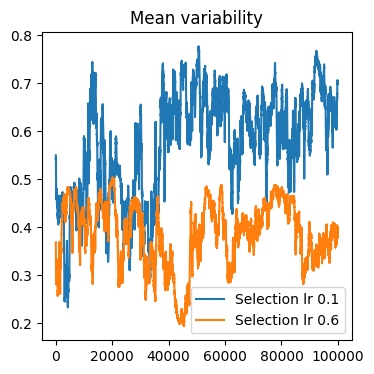

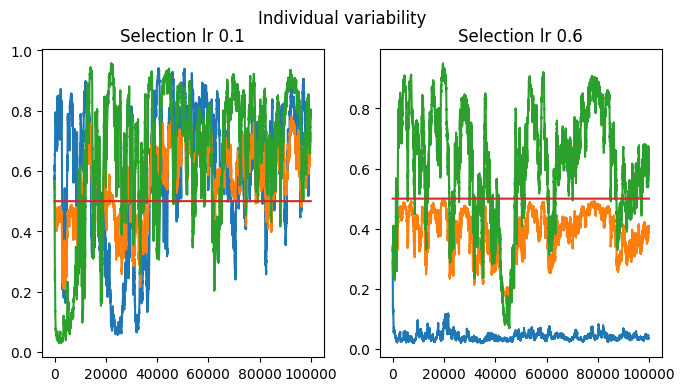

In [155]:
folders = [
    'SB_task_v2_learned_selection_iqn_20250214-16021739569532',
    'SB_task_v2_random_iqn_20250215-17021739657418',
]
folders = [
    'SB_task_v2_learned_selection_20250214-11021739550211',
    'SB_task_v2_random_20250214-11021739550153',
]
folders = [
    'SB_task_v3_learned_selection_reset_var_high_20250217-21021739844258',
    'SB_task_v3_learned_selection_reset_var_high_0.6_20250217-21021739844847'
]
    
labels = ['Selection lr 0.1', 'Selection lr 0.6']
plot_data_per_condition(folders, 100, 'variability', 'partner', labels, False)

reward

In [153]:
# folders = [
#     'SB_task_v3_learned_selection_reset_var_high_20250217-21021739844258',
#     'SB_task_v3_learned_selection_reset_var_high_0.6_20250217-21021739844847'
# ]
# folders = [
#     'SB_task_v3_learned_selection_reset_var_high_0.6_20250217-21021739844847',
#     'SB_task_v3_random_reset_var_high_0.6_with_self_var_with_partner_var_20250218-11021739897094'
# ]

folders = [
    'sanity_check_four_trainable_learned_selection_with_reset_varydecider_len10_20250224-21021740449358',
    'sanity_check_four_trainable_random_selection_with_reset_varydecider_len10_20250224-21021740449346'
]
# folders = [
#     'sanity_check_two_trainable_learned_selection_with_reset_fixeddecider_len10_20250224-21021740449783',
#     'sanity_check_two_trainable_random_selection_with_reset_fixeddecider_len10_20250224-21021740449767',
# ]
collective_rs = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'Reward' in f:
            if 'Agent_0'  not in f:
                data = pd.read_csv(os.path.join(parent_dir, f))
                collective_rs[ixs].append(data['Value'].to_numpy()[:])
collective_rs_avg = [np.mean(trim_and_calculate_mean(collective_rs[i]), axis=0) for i in range(len(collective_rs))]

In [ ]:
# combine the data from different checkpoints
folders_1 = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

folders_2 = [
    '',
    '',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_resume_20241219-11121734626833'
]

folders_all = [folders_1, folders_2]

entity_name = 'Reward'
agents_num = [2,3,6] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    data = pd.read_csv(sub_dir)

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_rs_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0.5, 1.0, 'partner R')

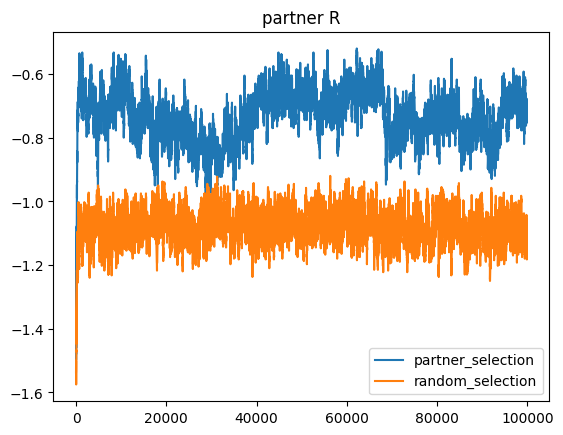

In [154]:
# partner pool avg r
labels = ['Selection lr 0.1', 'Selection lr 0.6']
labels = ['partner_selection', 'random_selection']
# alpha = 0.99
wsize = 100
for ixs, d in enumerate(collective_rs_avg):
    # plt.plot(exponential_moving_average(d, 0.01), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('partner R')

Text(0.5, 1.0, 'decider R')

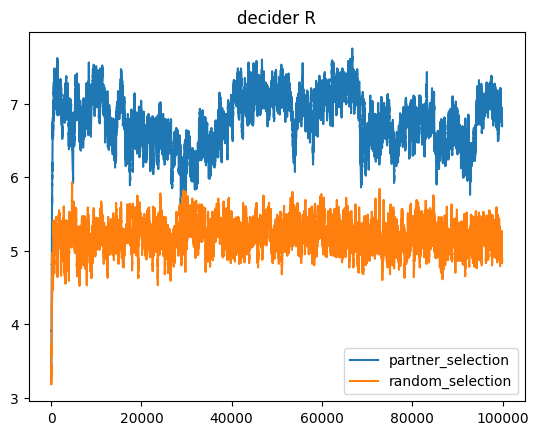

In [152]:
labels = ['Selection lr 0.1', 'Selection lr 0.6']
labels = ['partner_selection', 'random_selection']
# alpha = 0.99
wsize = 100
for ixs, d in enumerate(collective_rs_avg):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('decider R')

Text(0.5, 0.98, 'Reward')

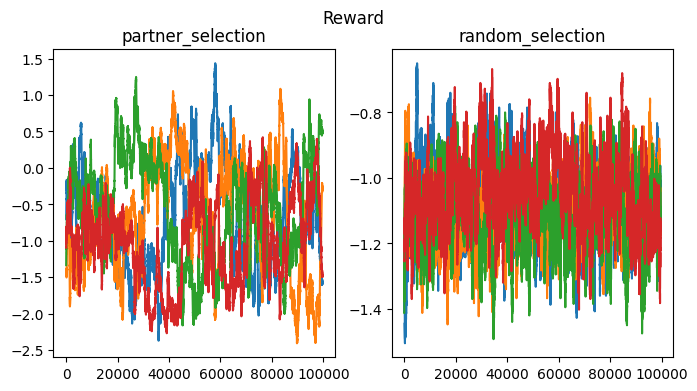

In [45]:
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 400
for i in range(len(labels)):
    for j in range(len(collective_rs[i])):
        axes[i].plot(rolling_average(collective_rs[i][j], wsize), label=j)
    axes[i].set_title(labels[i])
    # axes[i].legend()
plt.suptitle('Reward')


In [9]:
import numpy as np
arr = np.array([1., 0.])
result = np.repeat(arr[np.newaxis, :], repeats=2, axis=0)
result


array([[1., 0.],
       [1., 0.]])

Variability

In [140]:

folders = [
    'sanity_check_four_trainable_learned_selection_with_reset_varydecider_len10_20250224-21021740449358',
    'sanity_check_four_trainable_random_selection_with_reset_varydecider_len10_20250224-21021740449346'
]
# folders = [
#     'sanity_check_two_trainable_learned_selection_with_reset_fixeddecider_len10_20250224-21021740449783',
#     'sanity_check_two_trainable_random_selection_with_reset_fixeddecider_len10_20250224-21021740449767',
# ]
collective_d = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        pattern = r"^Agent_\d+_entropy_data.csv$"
        if bool(re.match(pattern, f)):
            if 'Agent_0' not in f:
                data = pd.read_csv(os.path.join(parent_dir, f))
                collective_d[ixs].append(data['Value'].to_numpy()[:])
collective_d_avg = [np.mean(trim_and_calculate_mean(collective_d[i]), axis=0) for i in range(len(collective_d))]

partner selection nan
random selection nan


Text(0.5, 0.98, 'Entropy')

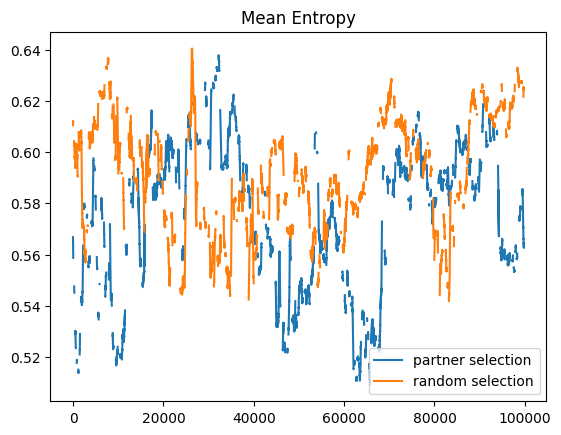

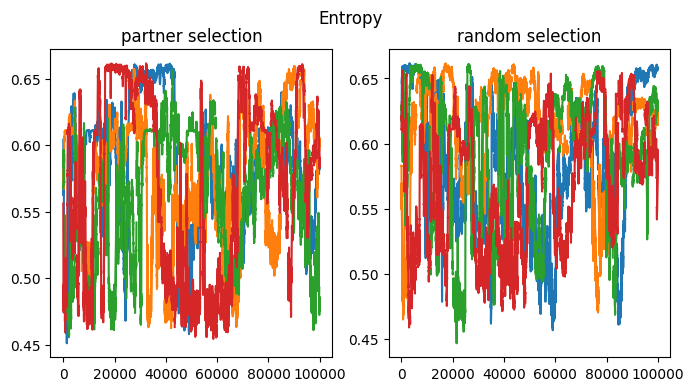

In [143]:
labels = ['simple learning', 'simple random', 'selection', 'random']
labels = ['partner selection', 'random selection']
# labels = ['partner selection w/o var information', 'random selection']

# labels = ['Selection lr 0.1', 'Selection lr 0.6']

# alpha = 0.99
wsize = 200
for ixs, d in enumerate(collective_d_avg):
    # plt.plot(exponential_moving_average(d, 1), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
    # plt.plot(d)

    print(labels[ixs], np.mean(d))
plt.legend()
plt.title('Mean Entropy')

fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 100
for i in range(len(labels)):
    for j in range(len(collective_d[i])):
        axes[i].plot(rolling_average(collective_d[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Entropy')

In [36]:
folders = [
    'multi_partners_learned_selection_without_partner_preference_20250223-15021740343749',
    'multi_partners_random_selection_without_partner_preference_20250222-23021740284025'
]
collective_d = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        pattern = r"^Agent_0_action_freq_action_/d$"
        # if bool(re.match(pattern, f)):
        if f.startswith('Agent_0_action_freq_action_'):
            sub_dir = os.path.join(parent_dir, f)
            sub_file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, sub_file))
            collective_d[ixs].append(data['Value'].to_numpy()[:])
collective_d_avg = [np.mean(trim_and_calculate_mean(collective_d[i]), axis=0) for i in range(len(collective_d))]

Text(0.5, 0.98, 'action_selection_freq')

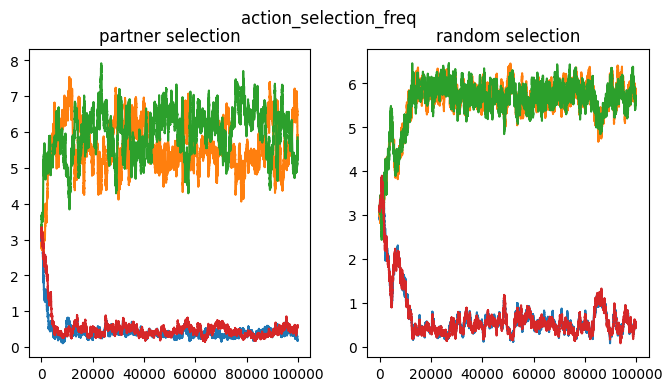

In [38]:
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 200
for i in range(len(labels)):
    for j in range(len(collective_d[i])):
        axes[i].plot(rolling_average(collective_d[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('action_selection_freq')

preference type

In [144]:

folders = [
    'sanity_check_four_trainable_learned_selection_with_reset_varydecider_len10_20250224-21021740449358',
    'sanity_check_four_trainable_random_selection_with_reset_varydecider_len10_20250224-21021740449346'
]
# folders = [
#     'sanity_check_two_trainable_learned_selection_with_reset_fixeddecider_len10_20250224-21021740449783',
#     'sanity_check_two_trainable_random_selection_with_reset_fixeddecider_len10_20250224-21021740449767',
# ]
collective_d = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        pattern = r"^Agent_\d+_dominant_pref_data.csv$"
        if bool(re.match(pattern, f)):
            if 'Agent_0' not in f:
                data = pd.read_csv(os.path.join(parent_dir, f))
                collective_d[ixs].append(data['Value'].to_numpy()[:])
collective_d_avg = [np.mean(trim_and_calculate_mean(collective_d[i]), axis=0) for i in range(len(collective_d))]

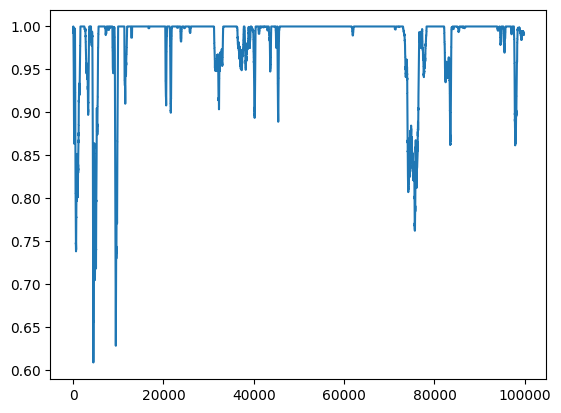

In [108]:
plt.plot(rolling_average(collective_d[0][1], wsize))

Text(0.5, 0.98, 'dominant_preference_type')

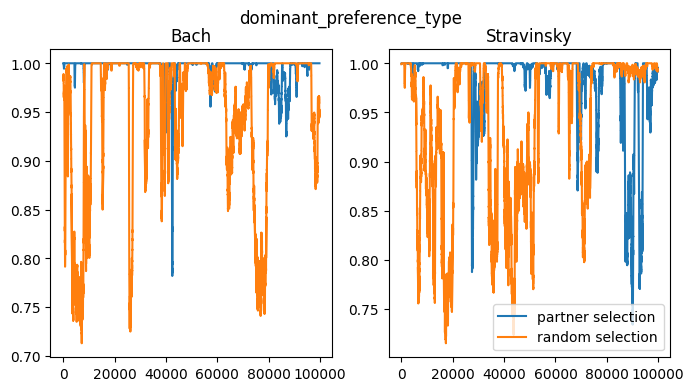

In [145]:
labels = ['partner selection', 'random selection']
choice_labels = ['Bach', 'Stravinsky']

fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 200
for i in range(len(collective_d)):
    axes[i].set_title(choice_labels[i])
    for j in range(len(labels)):
        axes[i].plot(rolling_average(collective_d[j][i], wsize), label=labels[j])
        
plt.legend()
plt.suptitle('dominant_preference_type')

Text(0.5, 0.98, 'main_preference_type')

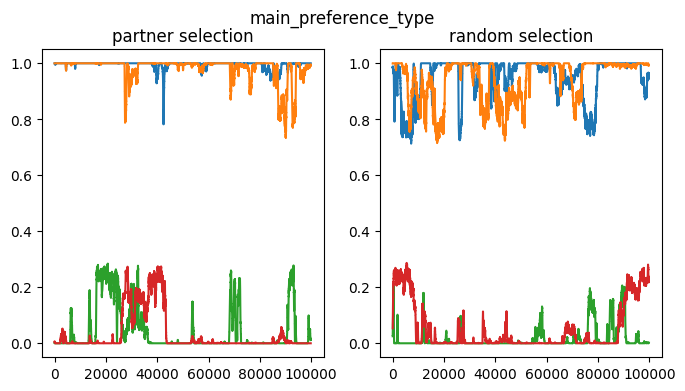

In [146]:
labels = ['partner selection', 'random selection']

fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 200
for i in range(len(labels)):
    for j in range(len(collective_d[i])):
        axes[i].plot(rolling_average(collective_d[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('main_preference_type')

max preference val

In [147]:
folders = [
    'sanity_check_four_trainable_learned_selection_with_reset_varydecider_len10_20250224-21021740449358',
    'sanity_check_four_trainable_random_selection_with_reset_varydecider_len10_20250224-21021740449346'
]
# folders = [
#     'sanity_check_two_trainable_learned_selection_with_reset_fixeddecider_len10_20250224-21021740449783',
#     'sanity_check_two_trainable_random_selection_with_reset_fixeddecider_len10_20250224-21021740449767',
# ]
collective_d = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        pattern = r"^Agent_\d+_max_pref_data.csv$"
        if bool(re.match(pattern, f)):
            if 'Agent_0' not in f:
                data = pd.read_csv(os.path.join(parent_dir, f))
                collective_d[ixs].append(data['Value'].to_numpy()[:])
collective_d_avg = [np.mean(trim_and_calculate_mean(collective_d[i]), axis=0) for i in range(len(collective_d))]

In [121]:
len(collective_d[0])

2

Text(0.5, 0.98, 'max_preference_val')

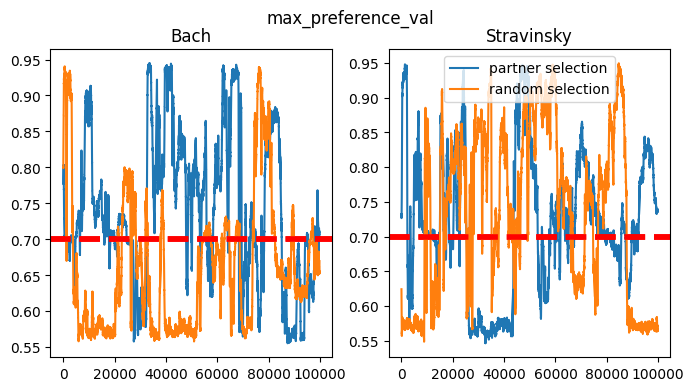

In [148]:
labels = ['partner selection', 'random selection']
choice_labels = ['Bach', 'Stravinsky']

fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 200
for i in range(len(collective_d)):
    axes[i].set_title(choice_labels[i])
    for j in range(len(labels)):
        axes[i].plot(rolling_average(collective_d[j][i], wsize), label=labels[j])
        axes[i].axhline(y=0.7, color='r', linestyle='--', linewidth=4) 
        
plt.legend()
plt.suptitle('max_preference_val')

partner selection 0.7534462486706675
random selection 0.7171340003101527


Text(0.5, 0.98, 'max_preference_val average')

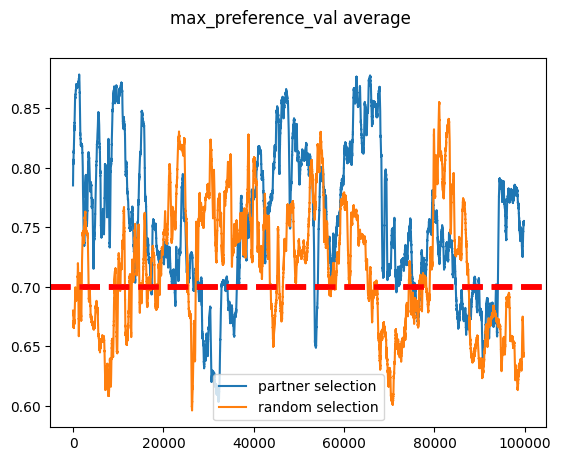

In [149]:
labels = ['partner selection', 'random selection']

wsize = 200
for ixs, d in enumerate(collective_d_avg):
    # plt.plot(exponential_moving_average(d, 1), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
    # plt.plot(d)
    plt.axhline(y=0.7, color='r', linestyle='--', linewidth=4) 
    print(labels[ixs], np.mean(d))
plt.legend()
plt.suptitle('max_preference_val average')

Freq of selecting more variable partner

In [220]:
folders = [
    'multiagent_test_v3_20250212-16021739396115',
    'multiagent_test_v3_random_20250212-18021739403723',
]
folders = [
    'SB_task_v1_learning_identity_info_20250212-16021739395067',
    'SB_task_v1_random_20250212-15021739393658',
    'SB_task_v1_learning_identity_info_social_comparison_20250212-19021739405711',
    'SB_task_v1_random_identity_info_social_comparison_20250213-12021739469069'
]
folders = [
    'SB_task_v2_learned_selection_iqn_20250214-16021739569532',
    'SB_task_v2_random_iqn_20250215-17021739657418',
]
folders = [
    'SB_task_v4_learned_selection_reset_var_high_0.6_no_self_var_no_partner_var_with_partner_app_20250218-21021739931370',
    'SB_task_v4_random_reset_var_high_0.6_no_self_var_no_partner_var_no_partner_app_20250218-15021739909689'
]
collective_d = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'select_more_variable' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_d[ixs].append(np.nan_to_num(data['Value'].to_numpy()[:], 0))
collective_d_avg = [np.mean(trim_and_calculate_mean(collective_d[i]), axis=0) for i in range(len(collective_d))]

In [90]:
collective_d

[[array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0.4848485 , 0.34375   , 0.34210527, ..., 0.30000001, 0.2647059 ,
         0.2857143 ])],
 [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0.61764705, 0.47499999, 0.58823532, ..., 0.58620691, 0.63333333,
         0.42424244])],
 [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0.51428574, 0.42105263, 0.45945945, ..., 0.45454547, 0.52941179,
         0.58620691])],
 [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0.48387095, 0.53125   , 0.34285715, ..., 0.52380955, 0.52941179,
         0.48275861])]]

partner selection w/o var information 0.08714852485641833
random selection 0.5000487518166005


Text(0.5, 0.98, 'select_more_variable')

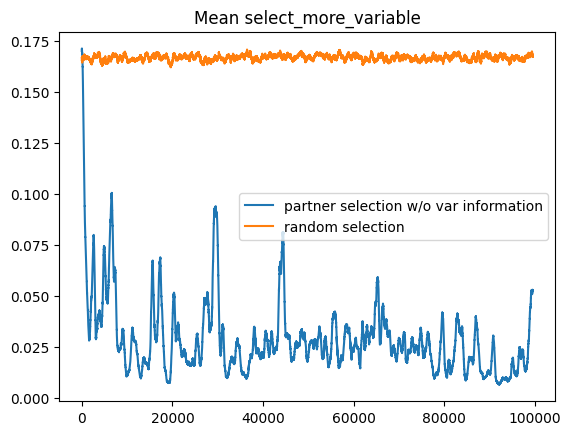

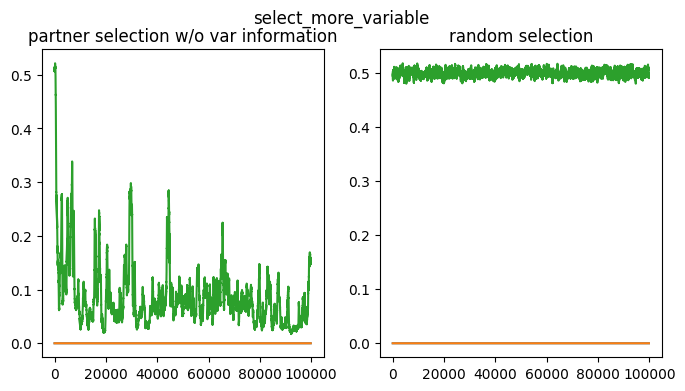

In [221]:
labels = ['simple learning', 'simple random', 'selection', 'random']
labels = ['selection', 'random']
labels = ['partner selection w/o var information', 'random selection']

# alpha = 0.99
wsize = 500
for ixs, d in enumerate(collective_d_avg):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
    print(labels[ixs], 3*np.mean(d))
plt.legend()
plt.title('Mean select_more_variable')

fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 200
for i in range(len(labels)):
    for j in range(len(collective_d[i])):
        axes[i].plot(rolling_average(collective_d[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('select_more_variable')

Freq of choosing different partners

In [216]:
folders = [
    'SB_task_v4_learned_selection_reset_var_high_0.6_no_self_var_no_partner_var_with_partner_app_20250218-21021739931370',
    'SB_task_v4_random_reset_var_high_0.6_no_self_var_no_partner_var_no_partner_app_20250218-15021739909689'
]
# folders = ['SB_task_v3_learned_selection_reset_var_high_0.6_no_self_var_no_partner_var_20250218-11021739895679']
collective_d = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'Agent_0' in f:
            if ('selection freq_Agent_1_selected' in f) or ('selection freq_Agent_2_selected' in f):
                sub_dir = os.path.join(parent_dir, f)            
                sub_file = os.listdir(sub_dir)[0]
                data = pd.read_csv(os.path.join(sub_dir, sub_file))
                collective_d[ixs].append(np.nan_to_num(data['Value'].to_numpy()[:], 0))
collective_d_avg = [np.mean(trim_and_calculate_mean(collective_d[i]), axis=0) for i in range(len(collective_d))]

In [185]:
len(collective_d[0])

2

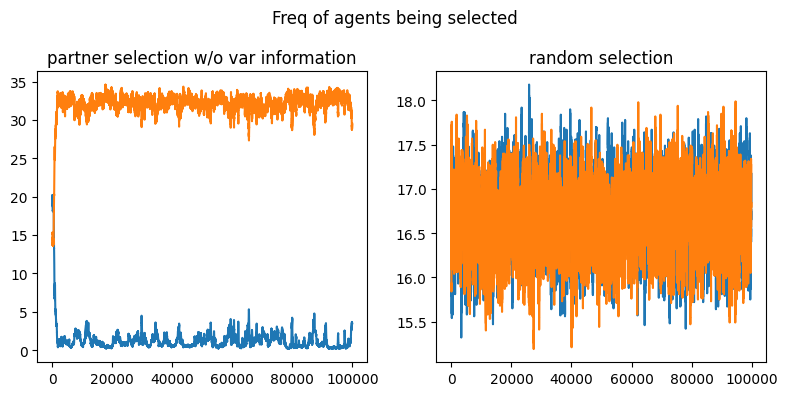

In [217]:
labels = ['Selection lr 0.6 w/o variability value shown']
labels = ['partner selection w/o var information', 'random selection']
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 100
for ixs, d in enumerate(collective_d):
    for ixs_a, d_a in enumerate(d):
        try:
            axes[ixs].plot(rolling_average(d[ixs_a], wsize), label=labels[ixs])
        except:
            plt.plot(rolling_average(d[ixs_a], wsize), label=labels[ixs])
    try:
        axes[ixs].set_title(labels[ixs])
    except:
        plt.title(labels[ixs])
plt.suptitle('Freq of agents being selected')
plt.tight_layout()
    

encounter_coins

In [100]:
folders = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

entity_name = 'Coin'
collective = [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):

    parent_dir = os.path.join('res', folder)
    items = os.listdir(parent_dir)

    for item in items:

        if entity_name in item:

            sub_dir = os.path.join(parent_dir, item)            
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective[ixs].append(data['Value'].to_numpy()[:]) # trim if needed

collective_ = [np.mean(collective[i], axis=0) for i in range(len(collective))]

In [ ]:
# combine different checkpoints
folders_1 = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

folders_2 = [
    '',
    '',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_resume_20241219-11121734626833'
]

folders_all = [folders_1, folders_2]

entity_name = 'Coin'
agents_num = [2,3,6] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0.5, 1.0, 'Coin')

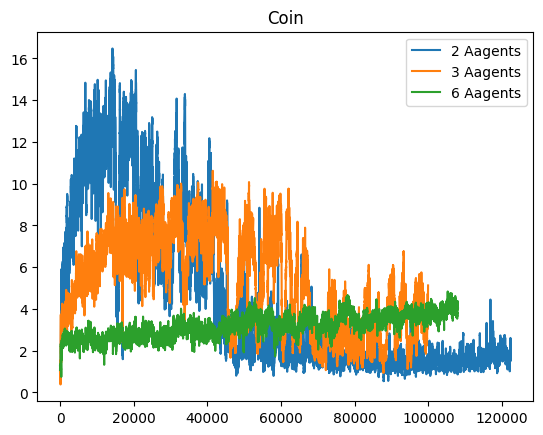

In [103]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']


alpha = 0.2
wsize = 50
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Coin')

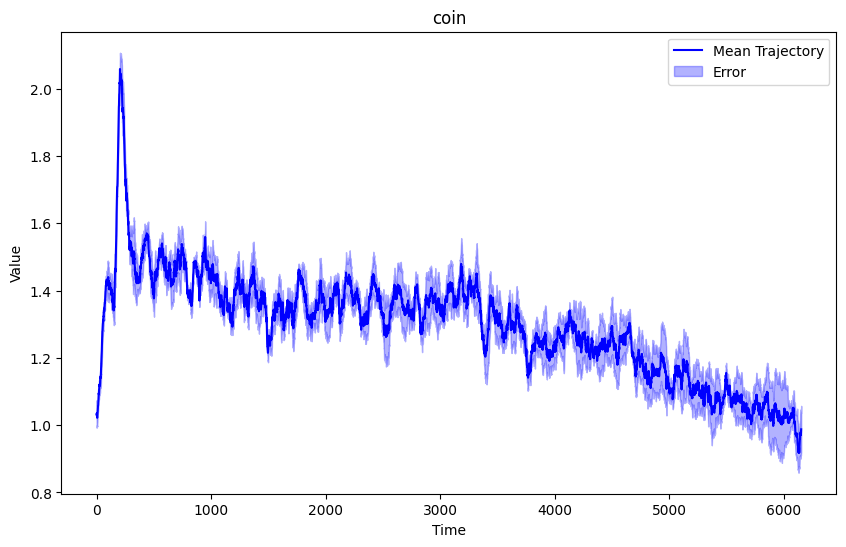

In [10]:
smoothed_collective_= [rolling_average(d, 50) for d in collective_]
plot_average_trajectory(smoothed_collective_, 'sem', title='coin')

Text(0.5, 0.98, 'Coin')

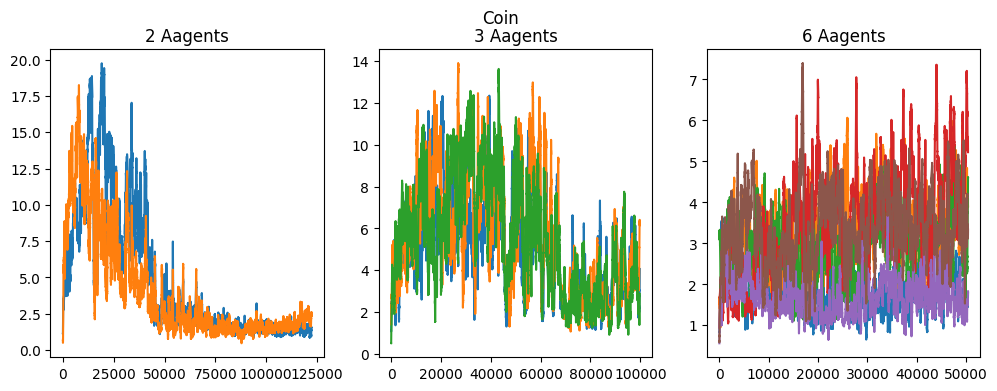

In [30]:
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 200
for i in range(len(labels)):
    for j in range(len(collective[i])):
        axes[i].plot(rolling_average(collective[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Coin')


Gem

In [39]:
folders = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

entity_name = 'Gem'
collective = [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):

    parent_dir = os.path.join('res', folder)
    items = os.listdir(parent_dir)

    for item in items:

        if entity_name in item:

            sub_dir = os.path.join(parent_dir, item)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective[ixs].append(data['Value'].to_numpy()[:])

collective_ = [np.mean(collective[i], axis=0) for i in range(len(collective))]

In [104]:
# combine different checkpoints
folders_1 = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

folders_2 = [
    '',
    '',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_resume_20241219-11121734626833'
]

folders_all = [folders_1, folders_2]

entity_name = 'Gem'
agents_num = [2,3,6] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0.5, 1.0, 'Gem')

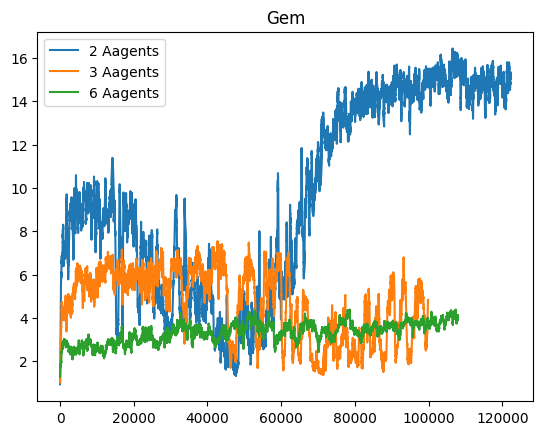

In [105]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']


alpha = 0.2
wsize = 200
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Gem')

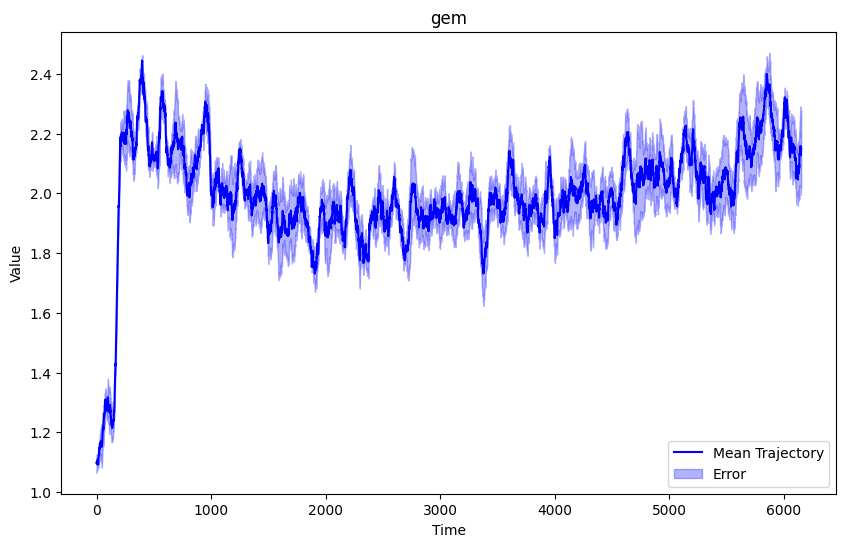

In [13]:
smoothed_collective_= [rolling_average(d, 50) for d in collective_]
plot_average_trajectory(smoothed_collective_, 'sem', title='gem')

Text(0.5, 0.98, 'Gem')

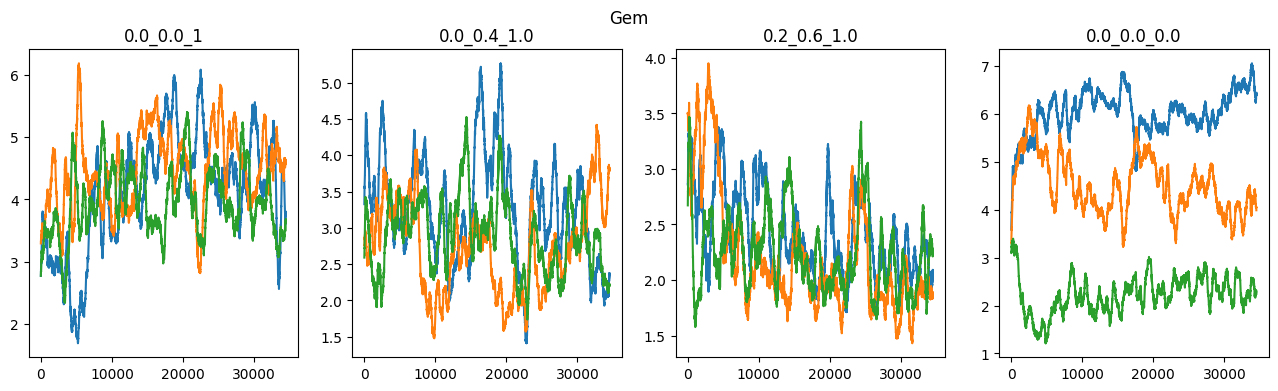

In [23]:
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 500

for i in range(len(labels)):
    for j in range(len(collective[i])):
        axes[i].plot(rolling_average(collective[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Gem')

bone

In [33]:
folders = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

entity_name = 'Bone'
collective = [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):

    parent_dir = os.path.join('res', folder)
    items = os.listdir(parent_dir)

    for item in items:

        if entity_name in item:

            sub_dir = os.path.join(parent_dir, item)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective[ixs].append(data['Value'].to_numpy()[:])

collective_ = [np.mean(collective[i], axis=0) for i in range(len(collective))]

/Users/socialai2/miniconda3/envs/state_punishment/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/socialai2/miniconda3/envs/state_punishment/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# combine different checkpoints
folders_1 = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

folders_2 = [
    '',
    '',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_resume_20241219-11121734626833'
]

folders_all = [folders_1, folders_2]

entity_name = 'Bone'
agents_num = [2,3,6] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0.5, 1.0, 'Bone')

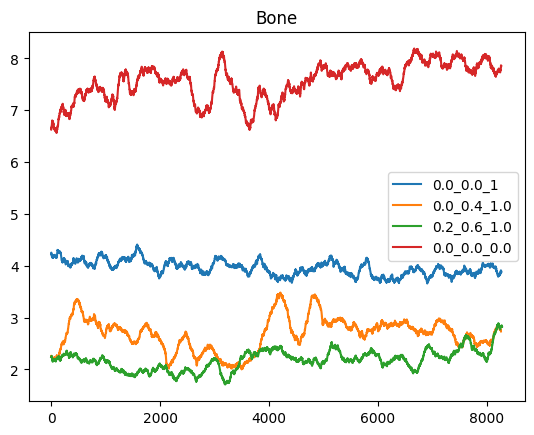

In [ ]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']


alpha = 0.2
wsize = 200
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Bone')

Text(0.5, 0.98, 'Bone')

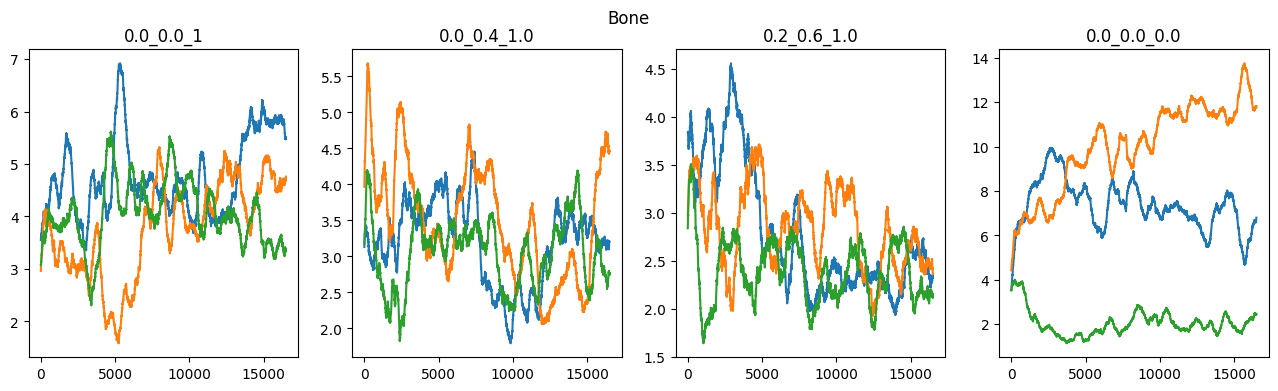

In [137]:
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 500

for i in range(len(labels)):
    for j in range(len(collective[i])):
        axes[i].plot(rolling_average(collective[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Bone')

wall

In [41]:
folders = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

entity_name = 'Wall'
collective = [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):

    parent_dir = os.path.join('res', folder)
    items = os.listdir(parent_dir)

    for item in items:

        if entity_name in item:

            sub_dir = os.path.join(parent_dir, item)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective[ixs].append(data['Value'].to_numpy()[:])

collective_ = [np.mean(collective[i], axis=0) for i in range(len(collective))]

In [106]:
# combine different checkpoints
folders_1 = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

folders_2 = [
    '',
    '',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_resume_20241219-11121734626833'
]

folders_all = [folders_1, folders_2]

entity_name = 'Wall'
agents_num = [2,3,6] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

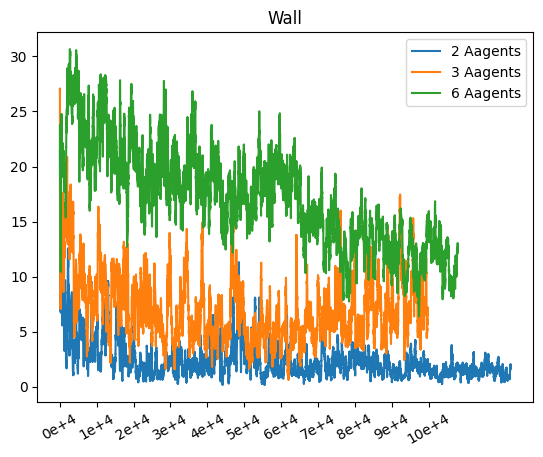

In [107]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']


alpha = 0.2
wsize = 200
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Wall')
plt.xticks([10000*i for i in range(11)], [f'{i}e+4' for i in range(11)], rotation=30);

state_punishment_level

In [122]:
folders = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]
collective = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'state_punishment_level_avg' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective[ixs].append(data['Value'].to_numpy()[:])
collective_ = [np.mean(trim_and_calculate_mean(collective[i]), axis=0) for i in range(len(collective))]

In [123]:
collective

[[array([0.        , 0.        , 0.465     , ..., 0.90750003, 0.92250001,
         0.90249997])],
 [array([0.0025    , 0.        , 0.        , ..., 0.815     , 0.79500002,
         0.6825    ])],
 [array([0.54250002, 0.95749998, 0.97500002, ..., 0.88999999, 0.75749999,
         0.86000001])]]

In [124]:
# combine different checkpoints
folders_1 = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

folders_2 = [
    '',
    '',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_resume_20241219-11121734626833'
]

folders_all = [folders_1, folders_2]

entity_name = 'state_punishment_level_avg'
agents_num = [1,1,1] # specify the number of agents in each condition
collective = [[] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    try: 
                        file = os.listdir(sub_dir)[0]
                        # data = pd.read_csv(os.path.join(sub_dir, file))
                    except: 
                        data = pd.read_csv(sub_dir)
                    
                    collective[ixs].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*condition_data)))] for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

In [121]:
collective_processed[2].shape

(108124,)

Text(0.5, 1.0, 'punishment prob')

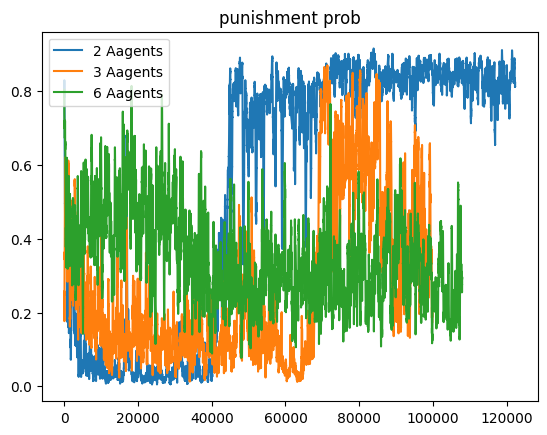

In [125]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']


alpha = 0.2
wsize = 200
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('punishment prob')

vote

In [61]:
# vote for punishment
folders = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]
collective_for = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'vote_for_punishment' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_for[ixs].append(data['Value'].to_numpy()[:])
collective_for_ = [np.mean(trim_and_calculate_mean(collective_for[i]), axis=0) for i in range(len(collective_for))]

In [130]:
# combine different checkpoints
folders_1 = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

folders_2 = [
    '',
    '',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_resume_20241219-11121734626833'
]

folders_all = [folders_1, folders_2]

entity_name = 'vote_for_punishment'
agents_num = [2,3,6] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    data = pd.read_csv(sub_dir)

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_for_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

In [62]:
# vote against punishment
folders = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]
collective_against = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'vote_against_punishment' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_against[ixs].append(data['Value'].to_numpy()[:])
collective_against_ = [np.mean(trim_and_calculate_mean(collective_against[i]), axis=0) for i in range(len(collective_against))]

In [131]:
# combine different checkpoints
folders_1 = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

folders_2 = [
    '',
    '',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_resume_20241219-11121734626833'
]

folders_all = [folders_1, folders_2]

entity_name = 'vote_against_punishment'
agents_num = [2,3,6] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    data = pd.read_csv(sub_dir)

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_against_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0.5, 1.0, 'increase')

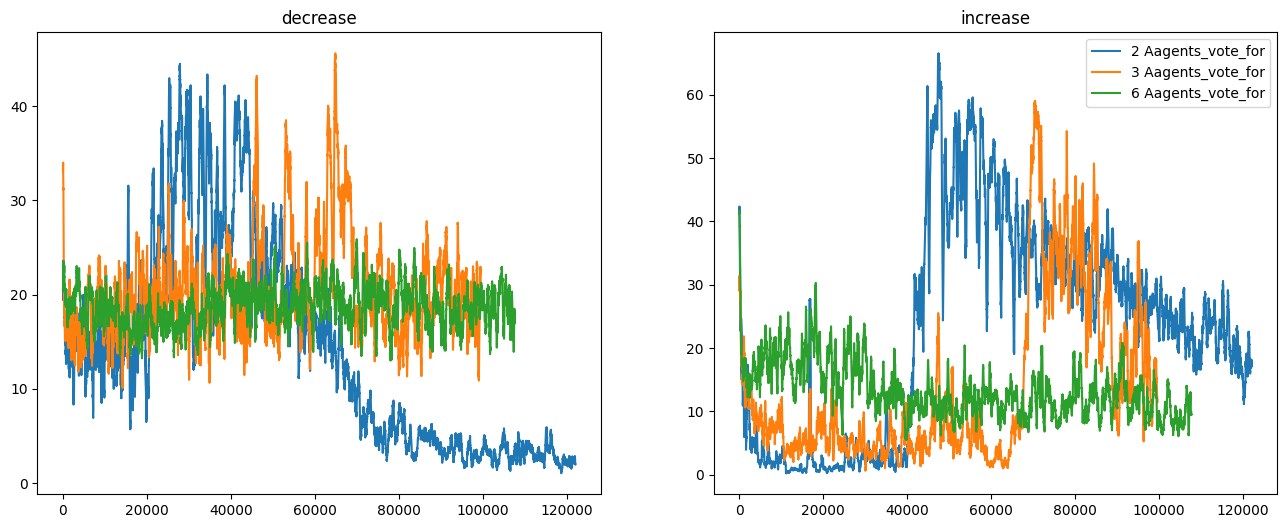

In [132]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

alpha = 0.2
wsize = 400
for ixs, d in enumerate(collective_against_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    axes[0].plot(rolling_average(d, wsize), label=labels[ixs]+'_vote_against')
for ixs, d in enumerate(collective_for_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    axes[1].plot(rolling_average(d, wsize), label=labels[ixs]+'_vote_for')
plt.legend()
axes[0].set_title('decrease')
axes[1].set_title('increase')